## Import qiskit and check version

In [2]:
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService

In [3]:
print(f"Current qiskit version: {qiskit.__version__}")

Current qiskit version: 1.4.0


### Connecting to IBM Service.

If this is your first time connecting to IBM Runtime Service, you should obtain an `API token` from IBM.

In [4]:
# API_token = "Insert_your_token_here"

# RuntimeService = QiskitRuntimeService(channel="ibm_quantum"
#                                     ,token = API_token)

# # Saving your token to your trusted local machine.
# QiskitRuntimeService.save_account(channel="ibm_quantum"
#                                 ,token = API_token
#                                 ,overwrite = True)


# If token is saved locally, you can simply do the following.
RuntimeService = QiskitRuntimeService(channel="ibm_quantum")

### Connecting to a specific IBM quantum device.

You have limited access per month with a free IBM Quantum account.

You can choose which quantum backend to connect to, or you can connect to a fake backend for simulation.

In [ ]:
# # Choosing the least busy backend
# backend = RuntimeService.get_least_busy(operational = True, simulator=False)

# # You can also use a fake backend for simulation. For heavier workloads, use qiskit Aer Simulator.
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane()


## Qiskit workflow

### Example workflow with 2-qubits

#### Step 1: Map the problem to a quantum circuit

Quantum circuit before hardware-specific optimization:


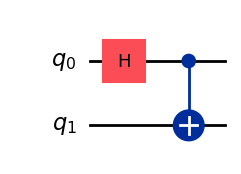

In [12]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0) # hadamat gate on qubit 0
qc.cx(0, 1) # controlled x gate on qubits 0 and 1

print("Quantum circuit before hardware-specific optimization:")
qc.draw(output='mpl')


In [7]:
# Choosing observables to measure. 

from qiskit.quantum_info import Pauli

ZZ = Pauli("ZZ")
ZI = Pauli("ZI") # Z on qubit 1, I on qubit 0
IZ = Pauli("IZ")
XX = Pauli("XX")
XI = Pauli("XI")
IX = Pauli("IX")

obs = [ZZ, ZI, IZ, XX, XI, IX]

#### Step 2: Optimize the circuit

We need to consider

1. Local connectivity between qubits

2. Native gate sets, or ISA (Instruction Set Architecture) of the qunatum hardware

Qiskit offers cusomizable `transpiler` (also called compiler) to optimize quantum circuits for execution on quantum hardware. 

The qiskit `transpiler` is built using customizable `pass_manager`. The transpiler can theoretically work with any quantum hardware, so long as detailed properties of the quantum hardware are provided, such as qubits connectivity, error rates, intruction set architecture and so on.

Quantum circuit after hardware-specific optimization:


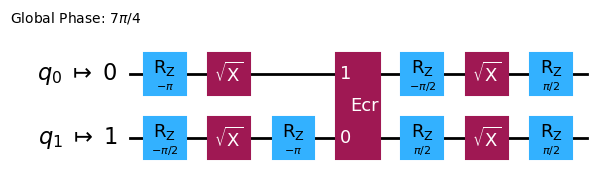

In [15]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=1, backend = backend)

qc_transpiled = pm.run(qc)

# Applying layout to observables
transpiled_obs = [ob.apply_layout(qc_transpiled.layout) for ob in obs]

# print(len(transpiled_obs))

print("Quantum circuit after hardware-specific optimization:")
# Draw the transpiled circuit
qc_transpiled.draw(output='mpl', idle_wires=False)

#### Step 3: Execute the circuit on a backend

For this example, we are using a fake backend, "FakeBrisbane." 

Normally, after submitting a request to the backend, a job ID is created and is put in queue. The job will be executed when the backend becomes available. 

We use the Job ID to check the status of the job. 

In [ ]:
from qiskit_aer.primitives import Estimator, EstimatorV2, Sampler, SamplerV2

estimator = EstimatorV2()
estimator.options.resilience_level = 1

job = estimator.run([(qc_transpiled, transpiled_obs)]) # This is a list of tuples

# Alternatively, since we have 6 circuits and 6 observables, we can use the following
# job = estimator.run([qc, qc, qc, qc, qc, qc], obs)


print(f">>> Job ID: {job.job_id()}")

>>> Job ID: 9a4df6f8-e08b-4bf7-8543-5afd184dea1e


In [ ]:
print("Result of the job:")
print(job.result())

Result of the job:
PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'target_precision': 0.0, 'circuit_metadata': {}, 'simulator_metadata': {'omp_enabled': True, 'parallel_experiments': 1, 'max_memory_mb': 40133, 'max_gpu_memory_mb': 0, 'time_taken_execute': 0.0003267, 'time_taken_parameter_binding': 4.2e-05}})], metadata={'version': 2})


#### Step 4: Post process the results

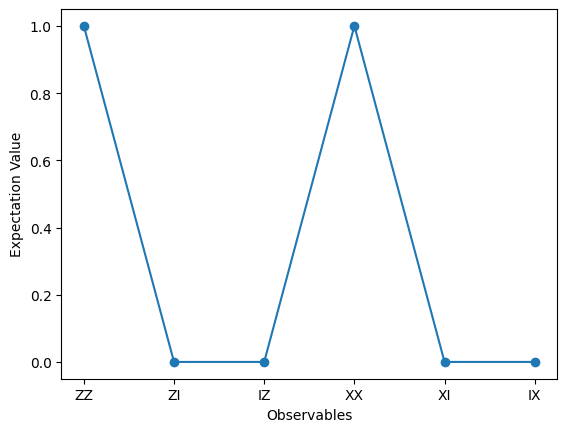

In [49]:
import matplotlib.pyplot as plt

data =["ZZ", "ZI", "IZ", "XX", "XI", "IX"]
values = job.result()[0].data.evs

plt.plot(data,values,"-o") # "-o" means solid line with circle points
plt.xlabel('Observables')
plt.ylabel('Expectation Value')
plt.show()